In [1]:
# pip install torch torchvision matplotlib pillow


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt
import copy
from IPython.display import display

In [3]:
# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 512 if torch.cuda.is_available() else 256

In [4]:
# --- Image Preprocessing ---
loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

unloader = transforms.ToPILImage()

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)  # add batch dimension
    return image.to(device, torch.float)

In [5]:
# --- Load Images ---
# content_img = image_loader("path_to_your_content_image.jpg")
content_img = image_loader("D:/DL_lab/DL6/original/dog_normal.jpg")

# style_img = image_loader("path_to_your_style_image.jpg")
style_img = image_loader("D:/DL_lab/DL6/styled/dog_ghibli_ref.jpg")

assert content_img.size() == style_img.size(), "Images must be of same size"

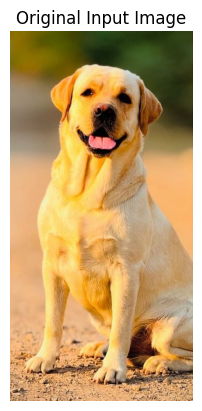

In [6]:
# --- Load Images ---
# content_img = image_loader("D:/DL_lab/DL6/original/dog_normal.jpg")

img_path = "D:/DL_lab/DL6/original/dog_normal.jpg"
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')
plt.title("Original Input Image")
plt.show()

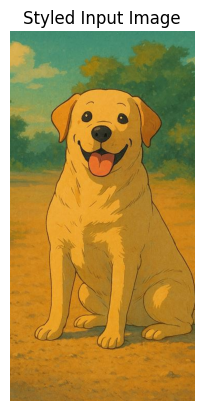

In [7]:
# --- Load Images ---
# style_img = image_loader("D:/DL_lab/DL6/styled/dog_ghibli_ref.jpg")

img_path2 = "D:/DL_lab/DL6/styled/dog_ghibli_ref.jpg"
img2 = Image.open(img_path2)

plt.imshow(img2)
plt.axis('off')
plt.title("Styled Input Image")
plt.show()

In [8]:
# style_pil.show(title="Styled/Reference Image")

In [9]:
# --- Display Function ---
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

In [10]:
# --- Loss Models ---
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

In [11]:
# # --- Load Pretrained VGG19 and Prepare Model ---
# cnn = models.vgg19(pretrained=True).features.to(device).eval()
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# class Normalization(nn.Module):
#     def __init__(self, mean, std):
#         super().__init__()
#         self.mean = mean.view(-1, 1, 1)
#         self.std = std.view(-1, 1, 1)

#     def forward(self, x):
#         return (x - self.mean) / self.std



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained VGG19 model using the new weights enum
weights = VGG19_Weights.DEFAULT
cnn = models.vgg19(weights=weights).features.to(device).eval()

# Use standard ImageNet normalization values (manually defined)
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Normalization layer
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, x):
        return (x - self.mean) / self.std

In [12]:
# --- Choose Layers for Style and Content ---
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img):
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0  # increment every time a conv is added
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Truncate layers after the last content/style loss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

In [13]:
# --- Optimization Setup ---
input_img = content_img.clone()
optimizer = optim.LBFGS([input_img.requires_grad_()])

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)

In [14]:
# --- Run Style Transfer ---
num_steps = 300
style_weight = 1e6
content_weight = 1

print("Optimizing...")
run = [0]
while run[0] <= num_steps:

    def closure():
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)

        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)

        loss = style_weight * style_score + content_weight * content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}:")
            print(f"Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")
        return loss

    optimizer.step(closure)


Optimizing...
Step 50:
Style Loss: 0.0001, Content Loss: 11.1811
Step 100:
Style Loss: 0.0000, Content Loss: 11.7861
Step 150:
Style Loss: 0.0000, Content Loss: 10.4868
Step 200:
Style Loss: 0.0000, Content Loss: 9.3643
Step 250:
Style Loss: 0.0000, Content Loss: 8.1828
Step 300:
Style Loss: 0.0000, Content Loss: 7.3010


In [15]:
# Finalize image
input_img.data.clamp_(0, 1)

tensor([[[[0.5388, 0.6743, 0.6832,  ..., 0.1906, 0.1880, 0.2639],
          [0.6731, 0.7373, 0.6884,  ..., 0.1922, 0.1038, 0.2269],
          [0.7002, 0.7417, 0.7261,  ..., 0.2384, 0.1982, 0.2428],
          ...,
          [0.6793, 0.6460, 0.6262,  ..., 0.7284, 0.6730, 0.6462],
          [0.7130, 0.6999, 0.6691,  ..., 0.6002, 0.5638, 0.5665],
          [0.7035, 0.6903, 0.6721,  ..., 0.6046, 0.5734, 0.6031]],

         [[0.4053, 0.4098, 0.4198,  ..., 0.4146, 0.4657, 0.5439],
          [0.4644, 0.4247, 0.4288,  ..., 0.4659, 0.4179, 0.4979],
          [0.4223, 0.3495, 0.3604,  ..., 0.4029, 0.4059, 0.4060],
          ...,
          [0.4485, 0.4761, 0.4729,  ..., 0.5302, 0.5128, 0.5421],
          [0.4530, 0.4899, 0.4888,  ..., 0.4814, 0.5039, 0.5155],
          [0.5016, 0.4864, 0.4748,  ..., 0.4658, 0.4673, 0.4350]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1414, 0.1463, 0.1262],
          [0.0000, 0.0148, 0.0460,  ..., 0.2498, 0.2264, 0.1483],
          [0.0000, 0.0689, 0.1483,  ..., 0

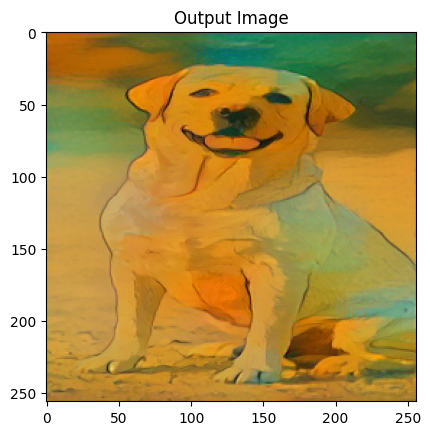

In [16]:
# --- Show Result ---
imshow(input_img, title="Output Image")
plt.show()